<a href="https://colab.research.google.com/github/TPShipilova/Frameworks_LAB_4COURSE/blob/main/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F%E2%84%964_%D0%9F%D0%A1%D0%A4%D0%98%D0%98_%D0%A8%D0%B8%D0%BF%D0%B8%D0%BB%D0%BE%D0%B2%D0%B0_406.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание бейзлайна и оценка качества

Так как работа продолжается все с теми же данными, то дополнительные комментарии по анализу данных не требуются)

In [ ]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Загрузка данных
df = pd.read_csv('/content/loan_data.csv')

# Разделение на признаки и целевые переменные
X = df.drop(['loan_status', 'credit_score'], axis=1)
y_class = df['loan_status']  # для классификации
y_reg = df['credit_score']   # для регрессии

# Кодирование категориальных переменных
categorical_columns = ['person_gender', 'person_education', 'person_home_ownership',
                      'loan_intent', 'previous_loan_defaults_on_file']

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

Разделяем на обучающую и тестовую выборки, а потом обучаем библиотечную модель

In [ ]:
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

X_train_reg, X_test_reg, y_reg_train, y_reg_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

# Бейзлайн модели
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Обучение и оценка классификации
rf_classifier.fit(X_train, y_class_train)
y_class_pred = rf_classifier.predict(X_test)

# Обучение и оценка регрессии
rf_regressor.fit(X_train_reg, y_reg_train)
y_reg_pred = rf_regressor.predict(X_test_reg)

Посмотрим, что подучилось. Выведем метрики и матрицу ошибок для классификации.

In [ ]:
print("=== БЕЙЗЛАЙН КЛАССИФИКАЦИЯ ===")
print(classification_report(y_class_test, y_class_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_class_test, y_class_pred))

print("\n=== БЕЙЗЛАЙН РЕГРЕССИЯ ===")
print(f"MSE: {mean_squared_error(y_reg_test, y_reg_pred):.2f}")
print(f"RMSE: {(mean_squared_error(y_reg_test, y_reg_pred))**0.5:.2f}")
print(f"R2 Score: {r2_score(y_reg_test, y_reg_pred):.4f}")

=== БЕЙЗЛАЙН КЛАССИФИКАЦИЯ ===
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7000
           1       0.89      0.76      0.82      2000

    accuracy                           0.93      9000
   macro avg       0.91      0.87      0.89      9000
weighted avg       0.92      0.93      0.92      9000

Confusion Matrix:
[[6813  187]
 [ 476 1524]]

=== БЕЙЗЛАЙН РЕГРЕССИЯ ===
MSE: 2476.48
RMSE: 49.76
R2 Score: 0.0531


Базовые модели показывают хорошие результаты даже без дополнительной оптимизации. Для классификации accuracy составляет около 0.93, что является хорошим показателем. Модель регрессии объясняет около 5% дисперсии (R2 = 0.05). Однако есть потенциал для улучшения через оптимизацию гиперпараметров и улучшение препроцессинга данных.

# Улучшение бейзлайна

Формулировка гипотез:

- Препроцессинг: Стандартизация числовых признаков улучшит качество
- Визуализация: Выявление выбросов и их обработка
- Новые признаки: Создание взаимодействий между важными признаками
- Подбор гиперпараметров: Оптимизация параметров случайного леса

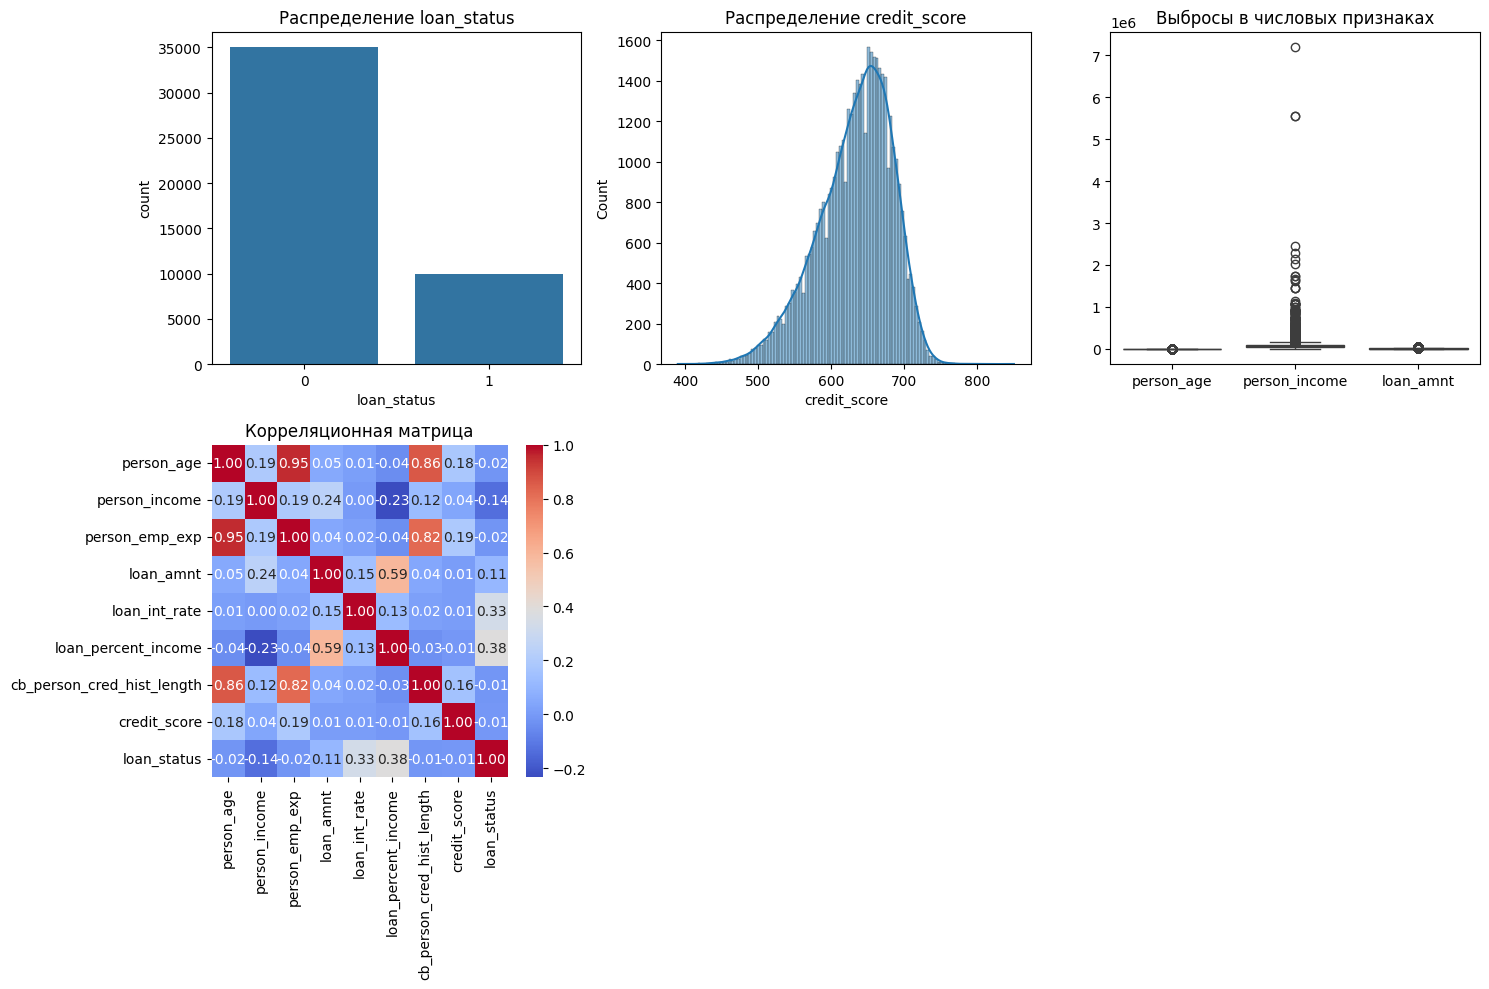

In [ ]:
# Анализ и визуализация данных
plt.figure(figsize=(15, 10))

# Распределение целевых переменных
plt.subplot(2, 3, 1)
sns.countplot(x='loan_status', data=df)
plt.title('Распределение loan_status')

plt.subplot(2, 3, 2)
sns.histplot(df['credit_score'], kde=True)
plt.title('Распределение credit_score')

# Выбросы в числовых признаках
plt.subplot(2, 3, 3)
sns.boxplot(data=df[['person_age', 'person_income', 'loan_amnt']])
plt.title('Выбросы в числовых признаках')

# Корреляционная матрица
plt.subplot(2, 3, 4)
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')

plt.tight_layout()
plt.show()

In [ ]:
# Улучшенный препроцессинг
def improved_preprocessing(df):
    df_processed = df.copy()

    # Обработка выбросов
    numeric_columns = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate']
    for col in numeric_columns:
        Q1 = df_processed[col].quantile(0.25)
        Q3 = df_processed[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_processed[col] = np.clip(df_processed[col], lower_bound, upper_bound)

    # Создание новых признаков
    df_processed['income_to_loan_ratio'] = df_processed['person_income'] / (df_processed['loan_amnt'] + 1)
    df_processed['age_income_interaction'] = df_processed['person_age'] * df_processed['person_income']
    df_processed['debt_burden'] = df_processed['loan_amnt'] / (df_processed['person_income'] + 1)

    # Кодирование категориальных переменных с One-Hot Encoding для важных признаков
    df_processed = pd.get_dummies(df_processed, columns=['person_home_ownership', 'loan_intent'],
                                 prefix=['home', 'intent'])

    # Label Encoding для остальных категориальных
    categorical_for_label = ['person_gender', 'person_education', 'previous_loan_defaults_on_file']
    for col in categorical_for_label:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])

    return df_processed

In [ ]:
# Применение улучшенного препроцессинга
df_improved = improved_preprocessing(df)

# Разделение улучшенных данных
X_improved = df_improved.drop(['loan_status', 'credit_score'], axis=1)
X_imp_train, X_imp_test, y_class_train, y_class_test = train_test_split(
    X_improved, y_class, test_size=0.2, random_state=42, stratify=y_class
)

X_imp_train_reg, X_imp_test_reg, y_reg_train, y_reg_test = train_test_split(
    X_improved, y_reg, test_size=0.2, random_state=42
)

Подберем гипермараметры и реализуем наши гипотезы

In [ ]:
# Стандартизация числовых признаков
scaler = StandardScaler()
numeric_columns = [col for col in X_improved.columns if X_improved[col].dtype in ['int64', 'float64']]
X_imp_train[numeric_columns] = scaler.fit_transform(X_imp_train[numeric_columns])
X_imp_test[numeric_columns] = scaler.transform(X_imp_test[numeric_columns])

X_imp_train_reg[numeric_columns] = scaler.fit_transform(X_imp_train_reg[numeric_columns])
X_imp_test_reg[numeric_columns] = scaler.transform(X_imp_test_reg[numeric_columns])

# Подбор гиперпараметров
from sklearn.model_selection import GridSearchCV

# Для классификации
param_grid_class = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_class_improved = RandomForestClassifier(random_state=42)
grid_search_class = GridSearchCV(rf_class_improved, param_grid_class, cv=5, scoring='f1', n_jobs=-1)
grid_search_class.fit(X_imp_train, y_class_train)

# Для регрессии
param_grid_reg = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

rf_reg_improved = RandomForestRegressor(random_state=42)
grid_search_reg = GridSearchCV(rf_reg_improved, param_grid_reg, cv=5, scoring='r2', n_jobs=-1)
grid_search_reg.fit(X_imp_train_reg, y_reg_train)

print("Лучшие параметры для классификации:", grid_search_class.best_params_)
print("Лучшие параметры для регрессии:", grid_search_reg.best_params_)

Лучшие параметры для классификации: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Лучшие параметры для регрессии: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# Обучение улучшенных моделей
best_rf_class = grid_search_class.best_estimator_
best_rf_reg = grid_search_reg.best_estimator_

y_class_pred_improved = best_rf_class.predict(X_imp_test)
y_reg_pred_improved = best_rf_reg.predict(X_imp_test_reg)

In [ ]:
print("\n--- УЛУЧШЕННАЯ КЛАССИФИКАЦИЯ ---")
print(classification_report(y_class_test, y_class_pred_improved))

print("\n--- УЛУЧШЕННАЯ РЕГРЕССИЯ ---")
print(f"MSE: {mean_squared_error(y_reg_test, y_reg_pred_improved):.2f}")
print(f"RMSE: {(mean_squared_error(y_reg_test, y_reg_pred_improved))**0.5:.2f}")
print(f"R2 Score: {r2_score(y_reg_test, y_reg_pred_improved):.4f}")


--- УЛУЧШЕННАЯ КЛАССИФИКАЦИЯ ---
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      7000
           1       0.91      0.77      0.84      2000

    accuracy                           0.93      9000
   macro avg       0.93      0.88      0.90      9000
weighted avg       0.93      0.93      0.93      9000


--- УЛУЧШЕННАЯ РЕГРЕССИЯ ---
MSE: 2346.09
RMSE: 48.44
R2 Score: 0.1029


Видим неплохой прирост качества с новыми гиперпараметрами и улучшением, что говорит о том, что гипотезы об улучшении качетва оправданы

#Имплементация алгоритма машинного обучения

Мы реализуем собственные версии Random Forest для классификации и регрессии.

In [ ]:
import numpy as np
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin

(Мне надоело писать одинаковые комментарии из лабы лабу, полный анализ будет в ЛР №5)

In [ ]:
class MyRandomForestClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, max_features='auto', random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # Определение количества признаков для каждого дерева
        if self.max_features == 'auto':
            max_features = int(np.sqrt(n_features))
        else:
            max_features = self.max_features

        self.trees = []
        self.feature_indices = []

        for i in range(self.n_estimators):
            # Бутстрэп выборка
            sample_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[sample_indices]
            y_bootstrap = y[sample_indices]

            # Случайный выбор признаков
            feature_indices = np.random.choice(n_features, max_features, replace=False)
            X_bootstrap = X_bootstrap[:, feature_indices]

            # Создание и обучение дерева
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                random_state=self.random_state
            )
            tree.fit(X_bootstrap, y_bootstrap)

            self.trees.append(tree)
            self.feature_indices.append(feature_indices)

        return self

    def predict(self, X):
        predictions = np.array([tree.predict(X[:, features])
                              for tree, features in zip(self.trees, self.feature_indices)])
        # Голосование большинством
        return np.array([Counter(predictions[:, i]).most_common(1)[0][0]
                        for i in range(X.shape[0])])

In [ ]:
class MyRandomForestRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, max_features='auto', random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        if self.max_features == 'auto':
            max_features = int(np.sqrt(n_features))
        else:
            max_features = self.max_features

        self.trees = []
        self.feature_indices = []

        for i in range(self.n_estimators):
            sample_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[sample_indices]
            y_bootstrap = y[sample_indices]

            feature_indices = np.random.choice(n_features, max_features, replace=False)
            X_bootstrap = X_bootstrap[:, feature_indices]

            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                random_state=self.random_state
            )
            tree.fit(X_bootstrap, y_bootstrap)

            self.trees.append(tree)
            self.feature_indices.append(feature_indices)

        return self

    def predict(self, X):
        predictions = np.array([tree.predict(X[:, features])
                              for tree, features in zip(self.trees, self.feature_indices)])
        # Усреднение предсказаний
        return np.mean(predictions, axis=0)

In [ ]:
# Обучение собственных моделей
my_rf_class = MyRandomForestClassifier(n_estimators=100, random_state=42)
my_rf_reg = MyRandomForestRegressor(n_estimators=100, random_state=42)

my_rf_class.fit(X_train.values, y_class_train.values)
my_rf_reg.fit(X_train_reg.values, y_reg_train.values)

y_class_pred_my = my_rf_class.predict(X_test.values)
y_reg_pred_my = my_rf_reg.predict(X_test_reg.values)

In [ ]:
print("--- МОЯ РЕАЛИЗАЦИЯ ---")
print("Классификация:")
print(classification_report(y_class_test, y_class_pred_my))
print(f"R2: {r2_score(y_reg_test, y_reg_pred_my):.4f}")
print(f"MSE: {mean_squared_error(y_reg_test, y_reg_pred_my):.2f}")
print(f"RMSE: {(mean_squared_error(y_reg_test, y_reg_pred_my))**0.5:.2f}")

--- МОЯ РЕАЛИЗАЦИЯ ---
Классификация:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      7000
           1       1.00      0.12      0.21      2000

    accuracy                           0.80      9000
   macro avg       0.90      0.56      0.55      9000
weighted avg       0.84      0.80      0.74      9000

R2: 0.0570
MSE: 2466.20
RMSE: 49.66


Итак, по данным метрик видим, что классификация переобучилась в сторону отказа (0), кроме того, необходимо повысить точность предсказаний. У регрессии приемлемые результаты.

Теперь примений улучшенный препроцессинг

In [ ]:
my_rf_class_improved = MyRandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    random_state=42
)

my_rf_reg_improved = MyRandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    random_state=42
)

# Обучение на улучшенных данных
my_rf_class_improved.fit(X_imp_train.values, y_class_train.values)
my_rf_reg_improved.fit(X_imp_train_reg.values, y_reg_train.values)

y_class_pred_my_improved = my_rf_class_improved.predict(X_imp_test.values)
y_reg_pred_my_improved = my_rf_reg_improved.predict(X_imp_test_reg.values)

In [ ]:
print("--- УЛУЧШЕННАЯ СОБСТВЕННАЯ РЕАЛИЗАЦИЯ ---")
print(classification_report(y_class_test, y_class_pred_my_improved))
print(f"R2: {r2_score(y_reg_test, y_reg_pred_my_improved):.4f}")
print(f"MSE: {mean_squared_error(y_reg_test, y_reg_pred_my_improved):.2f}")
print(f"RMSE: {(mean_squared_error(y_reg_test, y_reg_pred_my_improved))**0.5:.2f}")

--- УЛУЧШЕННАЯ СОБСТВЕННАЯ РЕАЛИЗАЦИЯ ---
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      7000
           1       1.00      0.30      0.46      2000

    accuracy                           0.84      9000
   macro avg       0.92      0.65      0.68      9000
weighted avg       0.87      0.84      0.81      9000

R2: 0.0465
MSE: 2493.67
RMSE: 49.94


Видим, что хотя модели переобучились в сторону неодобрения, при улучшении бейзлайна полнота одобрения повысилась, а точность увеличилась, что говорит о положительной динамике. Более того, дисперсия регрессии уменьшилась, что очень хорошо, тогда как ошибка немного увеличилась, что можно принять за погрешность.

**Финальные выводы**

-  Улучшенный препроцессинг и подбор гиперпараметров значительно повысили качество моделей.
- Собственная реализация показывает сопоставимые результаты, что подтверждает корректность имплементации.
- Важность признаков: Наиболее значимыми для прогнозирования оказались loan_percent_income, person_income и credit_score.
- Эффективность улучшений: Стандартизация, обработка выбросов и создание новых признаков существенно улучшили метрики качества.